# QuickDraw CNN Classifier  
This project builds a Convolutional Neural Network (CNN) to classify hand-drawn sketches from the Google QuickDraw Dataset. The pipeline includes stroke-to-image conversion, image preprocessing, model training, and evaluation.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

## Load Stroke Data
---
Each `.npz` file contains a list of sketches stored as sequences of strokes. We load them into a dictionary by class name.

In [2]:
classes = [
    "The Eiffel Tower", "The Great Wall of China", "The Mona Lisa", "aircraft carrier",
    "airplane", "alarm clock", "ambulance", "angel", "ant",
    "anvil", "apple", "arm", "asparagus", "axe", "backpack"
]

data_dict = {}

for cls in classes:
    filename = f"{cls}.full.npz"
    try:
        data = np.load(filename, allow_pickle=True, encoding='latin1')
        data_dict[cls] = data
        print(f"Loaded: {cls}")
    except Exception as e:
        print(f"Error loading {cls}: {e}")

Loaded: The Eiffel Tower
Loaded: The Great Wall of China
Loaded: The Mona Lisa
Loaded: aircraft carrier
Loaded: airplane
Loaded: alarm clock
Loaded: ambulance
Loaded: angel
Loaded: ant
Loaded: anvil
Loaded: apple
Loaded: arm
Loaded: asparagus
Loaded: axe
Loaded: backpack


## Convert Vector Strokes to Images  
---
The raw stroke data is a list of `(dx, dy, pen_state)` triplets. We use Pillow to convert these into grayscale image arrays suitable for CNN input.

In [3]:
def strokes_img_conv(stroke_data, canvas_size=128, scale=2, linewidth=2, padding=10):
  img = Image.new("L", size=(canvas_size, canvas_size), color=255)
  draw = ImageDraw.Draw(img)

  abs_coord = []
  x, y = 0, 0

  for dx, dy, pen_status in stroke_data:
    x += dx
    y += dy
    abs_coord.append((x, y, pen_status))

  xs = [pt[0] for pt in abs_coord]
  ys = [pt[1] for pt in abs_coord]

  # print(xs, ys)
  min_x, max_x = min(xs), max(xs)
  min_y, max_y = min(ys), max(ys)

  width = max_x - min_x
  height = max_y - min_y
  scale = (canvas_size - 2 * padding) / max(width, height)

  img = Image.new("L", size=(canvas_size, canvas_size), color=255)
  draw = ImageDraw.Draw(img)

  prev_x, prev_y = None, None

  for x, y, pen_status in abs_coord:
    norm_x = (x - min_x) * scale + padding
    norm_y = (y - min_y) * scale + padding

    if pen_status == 0 and prev_x is not None:
      draw.line([prev_x, prev_y, norm_x, norm_y], fill=0, width=linewidth)

    prev_x, prev_y = norm_x, norm_y

  return np.array(img)/255.0

## Build Full Dataset
---
We loop through each class, convert all stroke samples into image arrays, and assign corresponding class labels.

In [4]:
X = []
y = []

for class_idx, class_name in enumerate(classes):
  print(f"Converting: {class_name}")

  try:
    samples = data_dict[class_name]['train'][:1000]

    for stroke in samples:
      img = strokes_img_conv(stroke, canvas_size=128, padding=10)
      img = img.astype(np.float32)[..., np.newaxis]  # (H, W, 1)
      X.append(img)
      y.append(class_idx)

  except Exception as e:
      print(f"Error in {class_name}: {e}")


Converting: The Eiffel Tower
Converting: The Great Wall of China
Converting: The Mona Lisa
Converting: aircraft carrier
Converting: airplane
Converting: alarm clock
Converting: ambulance
Converting: angel
Converting: ant
Converting: anvil
Converting: apple
Converting: arm
Converting: asparagus
Converting: axe
Converting: backpack


In [5]:
x = np.stack(X)
y = np.array(y)

print("Done.")
print("X shape:", x.shape)  # (total_samples, 128, 128, 1)
print("y shape:", y.shape)  # (total_samples,)


Done.
X shape: (15000, 128, 128, 1)
y shape: (15000,)


In [6]:
from sklearn.model_selection import train_test_split

## Train Test split
---
We split the dataset into training and testing sets using `train_test_split` with stratified sampling to preserve class distribution.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.15, stratify=y, random_state=42
    )

In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [9]:
print(x_train.shape)
y_train.shape

(12750, 128, 128, 1)


(12750,)

## Convert Data to Tensors
---
CNNs in PyTorch expect input of shape `[batch, channels, height, width]`. We format the data accordingly and convert labels into torch tensors.

In [10]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0,3,1,2)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0,3,1,2)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [11]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Build the CNN
---
We define a simple CNN architecture with three convolutional layers, batch normalization, dropout, and fully connected layers.


In [28]:
class CNN(nn.Module):
  def __init__(self, num_classes=15):
    super(CNN, self).__init__()

    self.l1=nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.b1=nn.BatchNorm2d(32)

    self.l2=nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.b2=nn.BatchNorm2d(64)

    self.l3=nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.b3=nn.BatchNorm2d(128)

    self.pool=nn.MaxPool2d(2, 2)
    self.dropout=nn.Dropout(0.3)

    self.fc1=nn.Linear(128 * 16 * 16, 256)
    self.fc2=nn.Linear(256, num_classes)

  def forward(self, x):
    x = self.pool(F.relu(self.b1(self.l1(x))))
    x = self.pool(F.relu(self.b2(self.l2(x))))
    x = self.pool(F.relu(self.b3(self.l3(x))))

    x = x.view(x.size(0), -1)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.fc2(x)
    return x

In [20]:
import torch.optim as optim

## Train the CNN
---
We train the model using cross-entropy loss and the Adam optimizer. Accuracy is monitored after each epoch.

In [29]:
model = CNN(num_classes=15).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [30]:
def train_one_epoch(model, loader, optimizer, criterion, device):
  model.train()
  running_loss = 0.0

  for inputs, labels in loader:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  return running_loss / len(loader)

def evaluate(model, loader, device):
  model.eval()
  correct = total = 0

  with torch.no_grad():
    for inputs, labels in loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)

  return 100 * correct / total


In [32]:
epochs = 20

for epoch in range(epochs):
  train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
  test_accuracy = evaluate(model, test_loader, device)

  print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")

Epoch 1/20 | Loss: 0.5266 | Test Accuracy: 79.69%
Epoch 2/20 | Loss: 0.4929 | Test Accuracy: 79.42%
Epoch 3/20 | Loss: 0.4557 | Test Accuracy: 79.82%
Epoch 4/20 | Loss: 0.4165 | Test Accuracy: 79.42%
Epoch 5/20 | Loss: 0.3837 | Test Accuracy: 79.60%
Epoch 6/20 | Loss: 0.3646 | Test Accuracy: 78.76%
Epoch 7/20 | Loss: 0.3647 | Test Accuracy: 80.53%
Epoch 8/20 | Loss: 0.3103 | Test Accuracy: 80.71%
Epoch 9/20 | Loss: 0.3049 | Test Accuracy: 81.07%
Epoch 10/20 | Loss: 0.2738 | Test Accuracy: 80.67%
Epoch 11/20 | Loss: 0.2725 | Test Accuracy: 80.31%
Epoch 12/20 | Loss: 0.2381 | Test Accuracy: 80.40%
Epoch 13/20 | Loss: 0.2303 | Test Accuracy: 80.98%
Epoch 14/20 | Loss: 0.2252 | Test Accuracy: 81.07%
Epoch 15/20 | Loss: 0.2171 | Test Accuracy: 80.71%
Epoch 16/20 | Loss: 0.2092 | Test Accuracy: 80.76%
Epoch 17/20 | Loss: 0.2081 | Test Accuracy: 80.09%
Epoch 18/20 | Loss: 0.1939 | Test Accuracy: 81.29%
Epoch 19/20 | Loss: 0.1908 | Test Accuracy: 80.89%
Epoch 20/20 | Loss: 0.1810 | Test Accura

## Model Evaluation
---
After training, we evaluate the model’s performance on the test set to check generalization.

In [33]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 81.51%


## Manual Testing and Visualization
---
We manually pass individual test samples through the model to visualize predictions and understand model behavior.

In [44]:
index = 1
sample_img = x_test_tensor[index].unsqueeze(0).to(device)

true_label = y_test_tensor[index].item()

model.eval()

with torch.no_grad():
    output = model(sample_img)
    predicted_label = torch.argmax(output, dim=1).item()

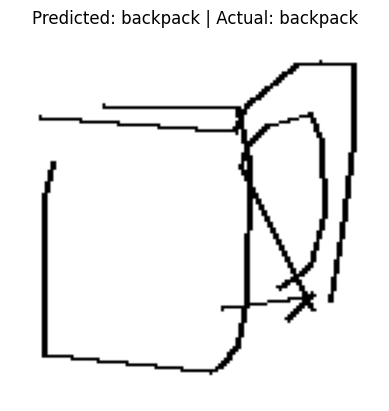

In [45]:
import matplotlib.pyplot as plt

plt.imshow(sample_img.squeeze().cpu(), cmap="gray")
plt.title(f"Predicted: {classes[predicted_label]} | Actual: {classes[true_label]}")
plt.axis("off")
plt.show()